In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import mysql_connection as mc

%matplotlib inline
sns.set_style("white")

# Time Series

In the last session, we looked at the seller side of olist. We started by just getting a feeling for how many there are and how they perform. In this section, we add one of the most critical dimensions when evaluating metrics: Time. That allows us to put our metrics in relation to the past, which in turn helps us to judge and thus conclude if we are performing better or worse than in the past.

We start by looking at anohter crucial component of our business: The number of incoming orders:

## No. of orders

In [2]:
conn = mc.connect()

Please insert your password:········


In [3]:
daily_orders_query = """
SELECT
    DATE(order_purchase_timestamp)  AS date_id,
    COUNT(*)                        AS no_of_orders
FROM olist.orders
WHERE order_purchase_timestamp > '2017-01-01'
GROUP BY 1
ORDER BY 1
"""

daily_orders = pd.read_sql(daily_orders_query, conn)

In [4]:
daily_orders.head()

,date_id,no_of_orders
0,2017-01-05,32
1,2017-01-06,4
2,2017-01-07,4
3,2017-01-08,6
4,2017-01-09,5


In [5]:
daily_orders.dtypes

date_id         object
no_of_orders     int64
dtype: object

In [6]:
daily_orders["date_id"] = pd.to_datetime(daily_orders["date_id"])

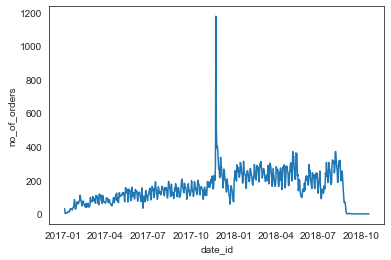

In [7]:
sns.lineplot(data=daily_orders,
             x="date_id",
             y="no_of_orders");

Too much detail on this graph. 
Group by weeks.

In [8]:
daily_orders.assign(day_of_week=daily_orders["date_id"].dt.dayofweek)

,date_id,no_of_orders,day_of_week
0,2017-01-05,32,3
1,2017-01-06,4,4
2,2017-01-07,4,5
3,2017-01-08,6,6
4,2017-01-09,5,0
...,...,...,...
614,2018-09-29,1,5
615,2018-10-01,1,0
616,2018-10-03,1,2
617,2018-10-16,1,1


In [9]:
# create new dataframe instead of overwriting the existing one
weekly_orders = daily_orders.copy()

In [10]:
weekly_orders = weekly_orders.assign(week_id=weekly_orders["date_id"] - pd.to_timedelta(weekly_orders["date_id"].dt.dayofweek, unit="D"))

In [11]:
weekly_orders = (weekly_orders
                 .groupby("week_id")
                 .agg({"no_of_orders": "sum"})
                 .reset_index())

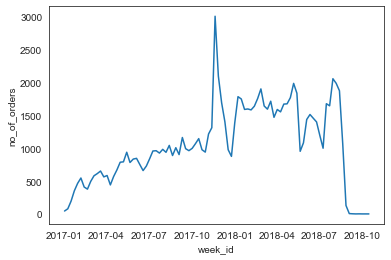

In [12]:
sns.lineplot(data=weekly_orders,
             x="week_id",
             y="no_of_orders");

Better, but still more variance than necessary.
Group by months.

In [13]:
monthly_orders = daily_orders.copy()
monthly_orders = (monthly_orders
                  .assign(month_id=pd.to_datetime(monthly_orders["date_id"].dt.strftime("%Y-%m-01")))
                  .groupby("month_id")
                  .agg({"no_of_orders": "sum"})
                  .reset_index())

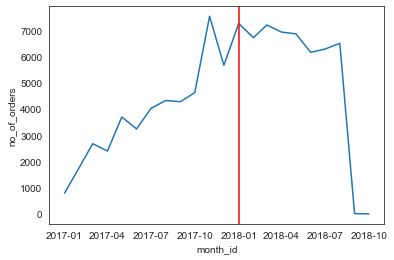

In [14]:
ax = sns.lineplot(data=monthly_orders,
                  x="month_id",
                  y="no_of_orders");
ax.axvline(pd.to_datetime("2018-01-01"), color="r");

Much better. In this graph, we can see that our number of orders have been increasing throughout 2017. Once 2018 started, however, the graph suggests that we stopped our growth trajectory. It even suggests that the number of monthly orders have been declining throughout the months.

An alternative way to plot that is to look at month in year, and compare the years with different lines:

No of orders in each month, by year:

| year | month | no_of_orders |
|------|-------|--------------|
| 2017 | 1     | 13536        |
| ...  | ...   | ...          |

In [15]:
monthly_orders = (monthly_orders
                  .assign(year=monthly_orders["month_id"].dt.year)
                  .assign(month=monthly_orders["month_id"].dt.month))

In [16]:
# exclude incomplete months
monthly_orders = monthly_orders.loc[monthly_orders["month_id"] < "2018-09-01"]

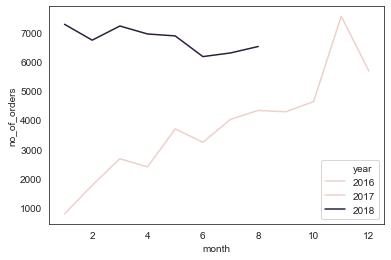

In [17]:
sns.lineplot(data=monthly_orders,
             x="month",
             y="no_of_orders",
             hue="year");

This view helps us in spotting multiple relationships at once. We can clearly see how each month compares to the previous month. It also allows us to remove seasonality. To remove seasonality, we can compare each month with the same month in the previous year.

mom := month over month growth

yoy := year over year growth

Show the same graphs for other metrics:

## Orders, Sellers, Items Sold, Revenue

In [18]:
monthly_perf_query = """
SELECT
    YEAR(o.order_purchase_timestamp)    AS year,
    MONTH(o.order_purchase_timestamp)   AS month,
    COUNT(DISTINCT o.order_id)          AS orders,
    SUM(1)                              AS items_sold,
    COUNT(DISTINCT oi.seller_id)        AS sellers,
    SUM(oi.price)                       AS revenue
FROM olist.order_items oi
    JOIN olist.orders o
    ON oi.order_id = o.order_id
WHERE order_purchase_timestamp >= '2017-01-01'
    AND order_purchase_timestamp < '2018-09-01'
GROUP BY 1,2
ORDER BY 1,2;"""

monthly_perf = pd.read_sql(monthly_perf_query, conn)

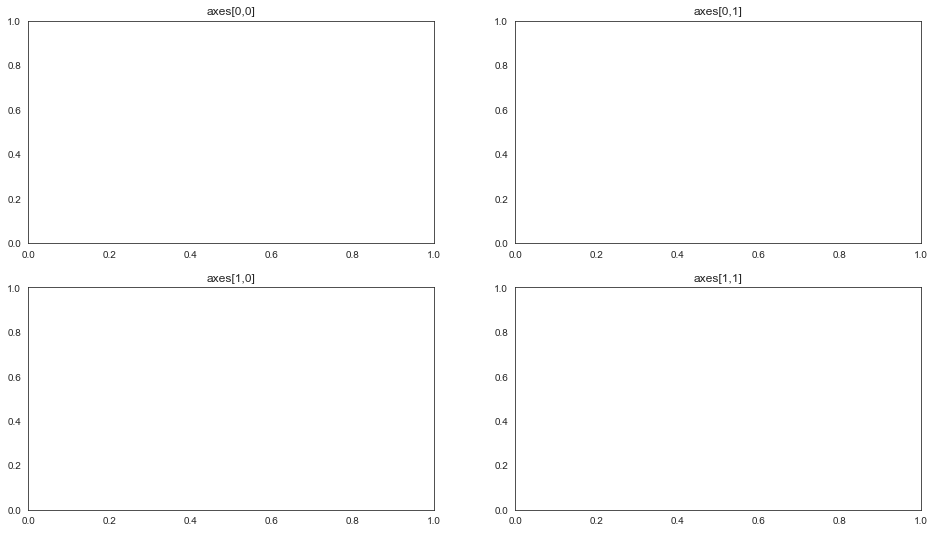

In [19]:
fig, axes = plt.subplots(nrows=2,
                         ncols=2,
                         figsize=(16,9))

axes[0,0].set_title("axes[0,0]");
axes[1,0].set_title("axes[1,0]");
axes[0,1].set_title("axes[0,1]");
axes[1,1].set_title("axes[1,1]");

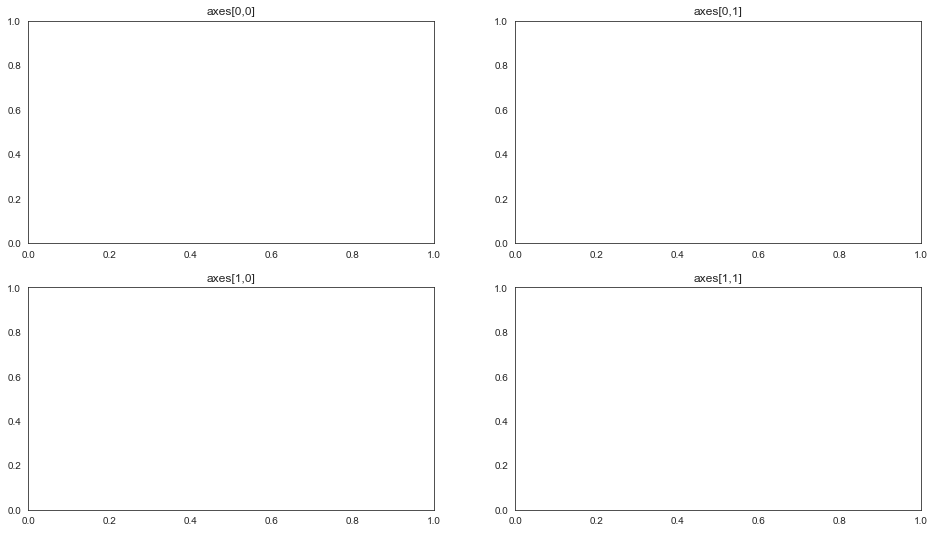

In [20]:
fig, axes = plt.subplots(nrows=2,
                         ncols=2,
                         figsize=(16,9))

for i in range(2):
    for j in range(2):
        axes[i,j].set_title(f"axes[{i},{j}]")

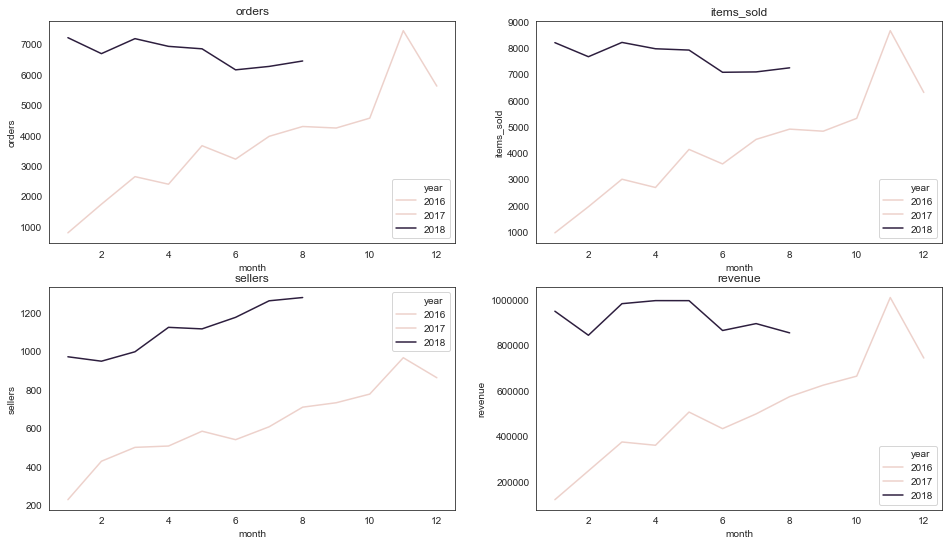

In [21]:
fig, axes = plt.subplots(nrows=2,
                         ncols=2,
                         figsize=(16,9))

metrics = ["orders", "items_sold", "sellers", "revenue",]

i = 0
for ax in axes.flatten():
    sns.lineplot(data=monthly_perf,
                 x="month",
                 y=metrics[i],
                 hue="year",
                 ax=ax);
    ax.set_title(metrics[i])
    i += 1

Plot:
- items sold per order (const)
- items sold per seller (down)
- revenue per item sold (up)

In [22]:
monthly_perf = (monthly_perf
                .assign(items_per_order=monthly_perf["items_sold"] / monthly_perf["orders"])
                .assign(items_per_seller=monthly_perf["items_sold"] / monthly_perf["sellers"])
                .assign(revenue_per_item=monthly_perf["revenue"] / monthly_perf["items_sold"]))

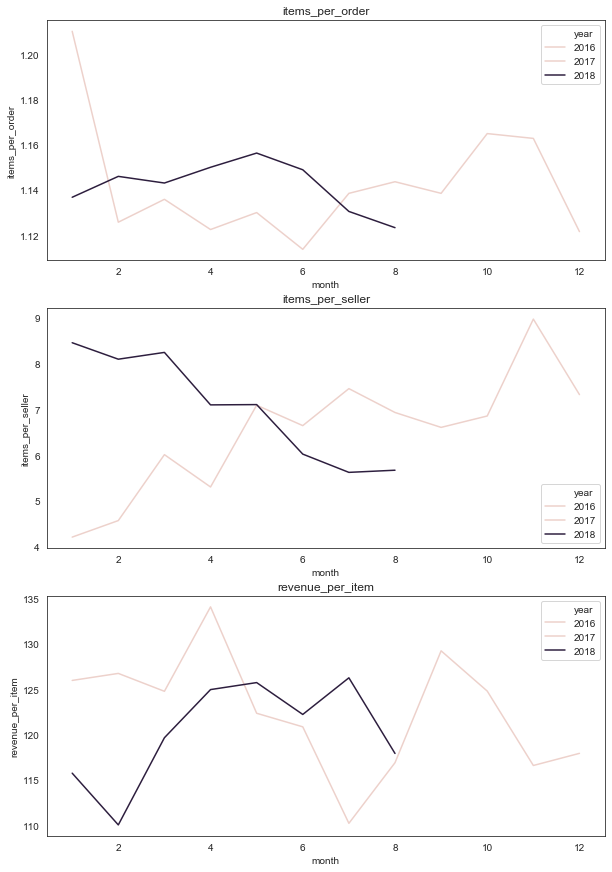

In [23]:
fig, axes = plt.subplots(nrows=3,
                         ncols=1,
                         figsize=(10,15))

ratios = ["items_per_order", "items_per_seller", "revenue_per_item"]

i = 0
for ax in axes:
    sns.lineplot(data=monthly_perf,
                 x="month",
                 y=ratios[i],
                 hue="year",
                 ax=ax);
    ax.set_title(ratios[i])
    i += 1

It seems like Orders and items sold were both declining. We can also see that the average number of items per order has been constant. However, looking at the sellers, it suggests that there are actually more unique sellers selling less items on average. We can also see that monthly revenue has been mostly constant. Hence, the revenue we generate for each order or item increases over time. The most concerning development is that of orders or items sold. 

In the following, we are going to dig a little bit into orders to find insights and actionable recommendations for management as to whether 
1) we should be worried about the decline and
2) if so, what we can do about it


## Drill into orders based on customer dimensions
### Split orders by customer stats

For that, we need a table that is structured like this:

| month_id | customer_state | orders |
|----------|----------------|--------|
| 2017-01-01 | SP           | 236    |
| ...        | ...          | ...    |

In [24]:
order_by_state_query = """
SELECT
    DATE_FORMAT(o.order_purchase_timestamp, '%Y-%m-01') AS month_id,
    c.customer_state,
    COUNT(*)                                            AS orders
FROM olist.orders o
    JOIN olist.customers c
    ON o.customer_id = c.customer_id
WHERE o.order_purchase_timestamp >= '2017-01-01'
    AND o.order_purchase_timestamp < '2018-09-01'
GROUP BY
    month_id,
    customer_state
ORDER BY
    month_id,
    customer_state"""

order_by_state = pd.read_sql(order_by_state_query, conn)

In [25]:
order_by_state.head()

,month_id,customer_state,orders
0,2017-01-01,AC,2
1,2017-01-01,AL,2
2,2017-01-01,BA,25
3,2017-01-01,CE,9
4,2017-01-01,DF,13


In [26]:
order_by_state["month_id"] = pd.to_datetime(order_by_state["month_id"])

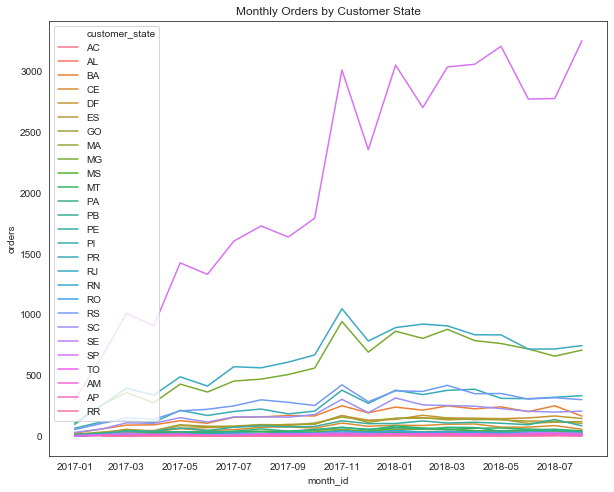

In [27]:
fig, ax = plt.subplots(figsize=(10,8))

sns.lineplot(data=order_by_state,
             x="month_id",
             y="orders",
             hue="customer_state",
             ax=ax).set_title("Monthly Orders by Customer State");

Remove the detail from smaller states

- Retrieve the top 5 states (by last full month: August)
- Group all remaining states into one "Other"

In [28]:
top_5_states = list(order_by_state
                    .loc[order_by_state["month_id"] == "2018-08-01"]
                    .sort_values("orders", ascending=False)
                    ["customer_state"]
                    [:5]
                    .values)
top_5_states

['SP', 'RJ', 'MG', 'PR', 'RS']

In [29]:
order_by_state.assign(grouped_customer_state=np.nan)

,month_id,customer_state,orders,grouped_customer_state
0,2017-01-01,AC,2,NaN
1,2017-01-01,AL,2,NaN
2,2017-01-01,BA,25,NaN
3,2017-01-01,CE,9,NaN
4,2017-01-01,DF,13,NaN
...,...,...,...,...
528,2018-08-01,RS,300,NaN
529,2018-08-01,SC,206,NaN
530,2018-08-01,SE,23,NaN
531,2018-08-01,SP,3253,NaN


In [30]:
# validate
order_by_state.assign(grouped_customer_state=np.where(order_by_state["customer_state"].isin(top_5_states), 
                                                      order_by_state["customer_state"],
                                                      "Other")).head(26)

,month_id,customer_state,orders,grouped_customer_state
0,2017-01-01,AC,2,Other
1,2017-01-01,AL,2,Other
2,2017-01-01,BA,25,Other
3,2017-01-01,CE,9,Other
4,2017-01-01,DF,13,Other
5,2017-01-01,ES,12,Other
6,2017-01-01,GO,18,Other
7,2017-01-01,MA,9,Other
8,2017-01-01,MG,108,MG
9,2017-01-01,MS,1,Other


In [31]:
order_by_gr_state = (order_by_state
                     .assign(grouped_customer_state=np.where(order_by_state["customer_state"].isin(top_5_states), 
                                                             order_by_state["customer_state"],
                                                             "Other"))
                     .groupby(["month_id", "grouped_customer_state"])
                     .agg({"orders": "sum"})
                     .reset_index())

In [34]:
order_by_gr_state.head()

,month_id,grouped_customer_state,orders
0,2017-01-01,MG,108
1,2017-01-01,Other,177
2,2017-01-01,PR,65
3,2017-01-01,RJ,97
4,2017-01-01,RS,54


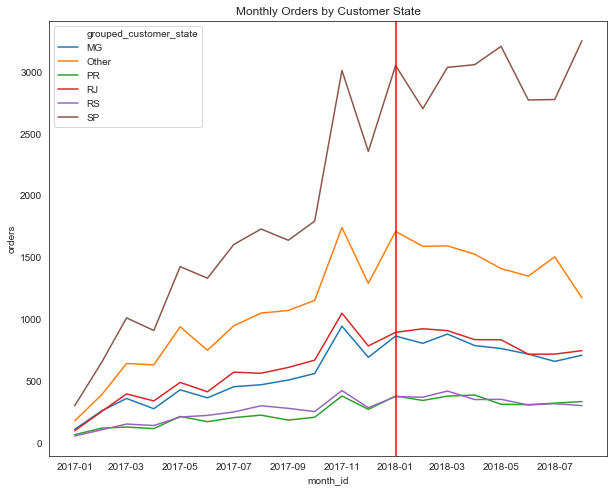

In [38]:
fig, ax = plt.subplots(figsize=(10,8))

sns.lineplot(data=order_by_gr_state,
             x="month_id",
             y="orders",
             hue="grouped_customer_state",
             ax=ax).set_title("Monthly Orders by Customer State");
ax.axvline(pd.to_datetime("2018-01-01"), color="r");

The graph suggests that orders placed by customers in Sao Paolo did not decrease as much as in other states. 

-> There may be a relationship between orders over time and the time it takes to deliver those orders, since we ship from Sao Paolo.

We can test this hypothesis through looking at the average number of days it takes for delivering the orders to the customers, grouped by states for 2018. 

In [39]:
avg_dd_per_state_query = """
SELECT
    c.customer_state,
    AVG(DATEDIFF(o.order_delivered_customer_date, o.order_purchase_timestamp)) AS avg_delivery_days
FROM olist.orders o
    JOIN olist.customers c
    ON o.customer_id = c.customer_id
WHERE order_status = 'delivered'
    AND order_purchase_timestamp > '2018-01-01'
GROUP BY c.customer_state;
"""

avg_gg_per_state = pd.read_sql(avg_dd_per_state_query, conn)

In [42]:
avg_gg_per_state.sort_values("avg_delivery_days")

,customer_state,avg_delivery_days
2,SP,8.2169
11,PR,11.5286
3,MG,11.7857
13,DF,12.3705
5,SC,14.5143
1,GO,15.0803
10,RS,15.2393
4,RJ,15.6823
17,ES,16.1576
16,MS,16.1582


Within the top 8 states, based on the lowest delivery time, 5 of our top states based on orders are present. This is an indication that we might be right. We can further dig into this by plotting a scatterplot that may indicate a correlation between a states decline in orders and their average delivery time.

### Correlation between decline in orders & delivery days for each state

We already have the delivery days by state for 2018.

We need to compute the relative growth between Aug 2018 and Jan 2018 for each state.
Make sure to use the same sample. In the calculation of the average deliver days, we excluded non-delivered orders. For our correlational analysis, we have to use the same sample

In [83]:
order_by_state_cl_query = """
SELECT
    DATE_FORMAT(o.order_purchase_timestamp, '%Y-%m-01') AS month_id,
    c.customer_state,
    COUNT(*)                                            AS orders
FROM olist.orders o
    JOIN olist.customers c
    ON o.customer_id = c.customer_id
WHERE o.order_purchase_timestamp >= '2017-01-01'
    AND o.order_purchase_timestamp < '2018-09-01'
    AND o.order_status = 'delivered'
GROUP BY
    month_id,
    customer_state
ORDER BY
    month_id,
    customer_state"""

order_by_state_cl = pd.read_sql(order_by_state_cl_query, conn)

### Calculate relative growth
Only for Sao Paolo as an example

In [48]:
sp_ex = order_by_state_cl.loc[order_by_state_cl["customer_state"] == "SP"].copy()

In [62]:
sp_ex

,month_id,customer_state,orders
22,2017-01-01,SP,283
49,2017-02-01,SP,601
76,2017-03-01,SP,966
102,2017-04-01,SP,873
129,2017-05-01,SP,1363
156,2017-06-01,SP,1284
183,2017-07-01,SP,1543
209,2017-08-01,SP,1665
236,2017-09-01,SP,1576
263,2017-10-01,SP,1723


In [59]:
sp_ex["month_id"] = pd.to_datetime(sp_ex["month_id"])

In [65]:
sp_ex = sp_ex.assign(shifted_month_id=sp_ex["month_id"] + pd.tseries.offsets.DateOffset(months=-7))

In [66]:
sp_ex

,month_id,customer_state,orders,shifted_month_id
22,2017-01-01,SP,283,2016-06-01
49,2017-02-01,SP,601,2016-07-01
76,2017-03-01,SP,966,2016-08-01
102,2017-04-01,SP,873,2016-09-01
129,2017-05-01,SP,1363,2016-10-01
156,2017-06-01,SP,1284,2016-11-01
183,2017-07-01,SP,1543,2016-12-01
209,2017-08-01,SP,1665,2017-01-01
236,2017-09-01,SP,1576,2017-02-01
263,2017-10-01,SP,1723,2017-03-01


In [69]:
sp_ex = (sp_ex
         .merge(sp_ex,
                how="inner",
                left_on="shifted_month_id",
                right_on="month_id")

In [73]:
sp_ex = (sp_ex
         [["month_id_x", "customer_state_x", "orders_x", "orders_y"]]
         .rename(columns={"month_id_x": "month_id",
                          "customer_state_x": "customer_state",
                          "orders_x": "orders",
                          "orders_y": "orders_jan"})
         .loc[sp_ex["month_id_x"] == "2018-08-01"])

In [75]:
(sp_ex["orders"] / sp_ex["orders_jan"]) - 1

12    0.063529
dtype: float64

**Apply that to all states**

In [84]:
order_by_state_cl["month_id"] = pd.to_datetime(order_by_state_cl["month_id"])

In [85]:
order_by_state_cl = order_by_state_cl.assign(shifted_month_id=order_by_state_cl["month_id"] + pd.tseries.offsets.DateOffset(months=-7))

In [86]:
order_by_state_cl = (order_by_state_cl
                     .merge(order_by_state_cl,
                            how="inner",
                            left_on=["shifted_month_id", "customer_state"],
                            right_on=["month_id", "customer_state"]))

In [88]:
order_by_state_cl = (order_by_state_cl
                     [["month_id_x", "customer_state", "orders_x", "orders_y"]]
                     .rename(columns={"month_id_x": "month_id",
                                      "orders_x": "orders",
                                      "orders_y": "orders_jan"})
                     .loc[order_by_state_cl["month_id_x"] == "2018-08-01"])

In [91]:
order_by_state_cl = order_by_state_cl.assign(rel_growth=(order_by_state_cl["orders"] / order_by_state_cl["orders_jan"]) - 1)

Alternatively, you can use the DataFrame.shift() method to avoid the tedious merge operation. You can also directly calculate the relative growth using the DataFrame.pct_change() method that also allows you to specify by how many periods you want to shift.

Create final DataFrame

In [96]:
states = (order_by_state_cl
          .merge(avg_gg_per_state,
                 how="inner",
                 on="customer_state"))
          ["customer_state", "rel_growth", "avg_delivery_days"])

In [99]:
states = states[["customer_state", "rel_growth", "avg_delivery_days"]]

In [100]:
states.head()

,customer_state,rel_growth,avg_delivery_days
0,AC,-0.500000,21.0741
1,AL,-0.555556,23.5859
2,AM,-0.666667,27.1250
3,AP,-0.818182,25.9744
4,BA,-0.302632,19.0788


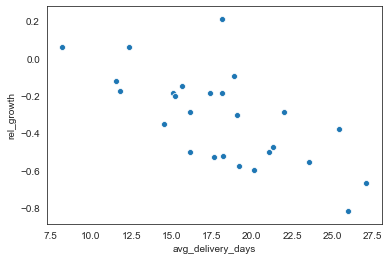

In [101]:
sns.scatterplot(data=states,
                x="avg_delivery_days",
                y="rel_growth");

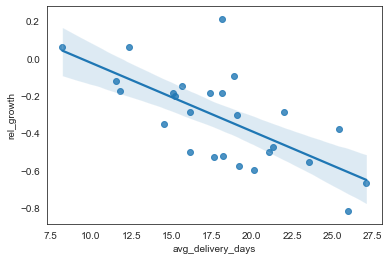

In [102]:
sns.regplot(data=states,
            x="avg_delivery_days",
            y="rel_growth");

In [104]:
states.corr()

,rel_growth,avg_delivery_days
rel_growth,1.000000,-0.679821
avg_delivery_days,-0.679821,1.000000


There is a negative correlation between the average delivery days of states and their growth in orders. The longer deliveries take on average, the stronger their relative decline in orders. 

-> Suggestion: We could evaluate whether building a second logistic facility would decrease the avg. delivery days and thus may stop the decline in incoming orders.